In [17]:
import pandas as pd
import jieba
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [18]:
df = pd.read_excel('产品评价.xlsx')

In [19]:
def clean_text(text):
    return ' '.join(jieba.cut(str(text)))

df['评论_clean'] = df['评论'].apply(clean_text)

In [20]:
# TF-IDF特征
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['评论_clean'])
y = df['评价']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {
    '朴素贝叶斯': MultinomialNB(),
    '逻辑回归': LogisticRegression(max_iter=200),
    '支持向量机': LinearSVC(),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'MLP': MLPClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'\n模型：{name}')
    print('准确率：', acc)
    print(classification_report(y_test, y_pred))


模型：朴素贝叶斯
准确率： 0.875
              precision    recall  f1-score   support

           0       1.00      0.70      0.83        91
           1       0.82      1.00      0.90       125

    accuracy                           0.88       216
   macro avg       0.91      0.85      0.86       216
weighted avg       0.90      0.88      0.87       216


模型：逻辑回归
准确率： 0.9814814814814815
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        91
           1       0.99      0.98      0.98       125

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216


模型：支持向量机
准确率： 0.9629629629629629
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        91
           1       0.99      0.94      0.97       125

    accuracy                           0.96       216
   macro avg       0.96      0.97      0

/opt/anaconda3/envs/tf-metal/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



模型：MLP
准确率： 0.9583333333333334
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        91
           1       0.98      0.94      0.96       125

    accuracy                           0.96       216
   macro avg       0.96      0.96      0.96       216
weighted avg       0.96      0.96      0.96       216



In [ ]:
import pandas as pd
import jieba
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


df = pd.read_excel('产品评价.xlsx')
df = df.dropna(subset=['评论', '评价'])

def clean_text(text):
    return ' '.join(jieba.cut(str(text)))

df['评论_clean'] = df['评论'].apply(clean_text)

# Tokenizer 序列化
max_words = 10000 # 词表大小
max_len = 100 # 每条评论的最大长度

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['评论_clean'])

X = tokenizer.texts_to_sequences(df['评论_clean'])
X = pad_sequences(X, maxlen=max_len)
y = np.array(df['评价'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate(X_test, y_test)
print(f"\n测试集准确率: {acc:.4f}")

def predict_comment(text):
    text_cut = ' '.join(jieba.cut(text))
    seq = tokenizer.texts_to_sequences([text_cut])
    seq = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(seq)[0][0]
    return "好评" if pred > 0.5 else "差评", float(pred)

print(predict_comment("这款手机手感非常棒，运行速度快"))
print(predict_comment("质量太差了，用了两天就坏"))

/opt/anaconda3/envs/tf-metal/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5977 - loss: 0.6552 - val_accuracy: 0.5954 - val_loss: 0.6140
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7410 - loss: 0.5523 - val_accuracy: 0.7977 - val_loss: 0.4988
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8654 - loss: 0.4211 - val_accuracy: 0.8613 - val_loss: 0.3505
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9161 - loss: 0.2711 - val_accuracy: 0.9653 - val_loss: 0.1699
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9522 - loss: 0.1784 - val_accuracy: 0.9538 - val_loss: 0.1419
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9653 - loss: 0.1063 - val_accuracy: 0.9538 - val_loss: 0.1771
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9826 - loss: 0.0866 - val_accuracy: 0.9595 - val_loss: 0.0734
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9812 - loss: 0.0666 - val_accuracy: 0.9595 - v

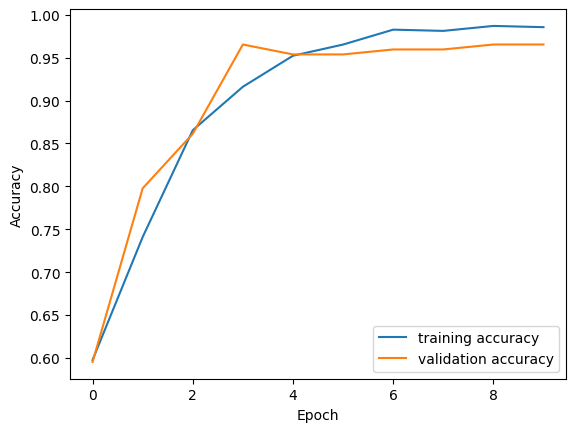

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()